# Histopathological cancer detection using Convolutional Neural Net

The data has been taken from a Kaggle challenge: https://www.kaggle.com/c/histopathologic-cancer-detection/overview
The aim of the project is to identify metastatic cancer in small image patches taken from larger digital pathology scans.

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import random

%matplotlib inline

In [2]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
# Example image
img = plt.imread('./train/f17f51f4df0f019d5caa5f587d9f3715890b8319.tif')
img.shape

(96, 96, 3)

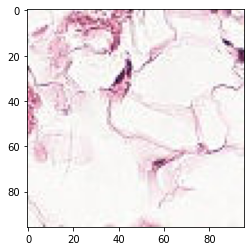

In [4]:
# Example image
plt.imshow(img)

# Load image data

In [5]:
# Read the train labels. Id = nomenclature of the image. label = whether the image contains a tumor
train_labels = pd.read_csv('./train_labels.csv')
train_labels.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [6]:
#Due to memory allocation problem we will work with a subset of the data
# Load the train images and train labels
train_len = len(train_labels)
subset_size=1
subset_len = int(train_len*subset_size)

X = []
y = []

for i in tqdm(range(subset_len)):
    filename = train_labels.loc[i, 'id']
    img = plt.imread('./train/'+filename+'.tif')
    img_label = train_labels.loc[i, 'label']
    X.append(img)
    y.append(img_label)

100%|██████████| 220025/220025 [26:41<00:00, 137.36it/s]


In [7]:
X = np.array(X)
y = np.array(y)

In [8]:
X.shape

(220025, 96, 96, 3)

In [9]:
y.shape

(220025,)

# Exploratory data analysis

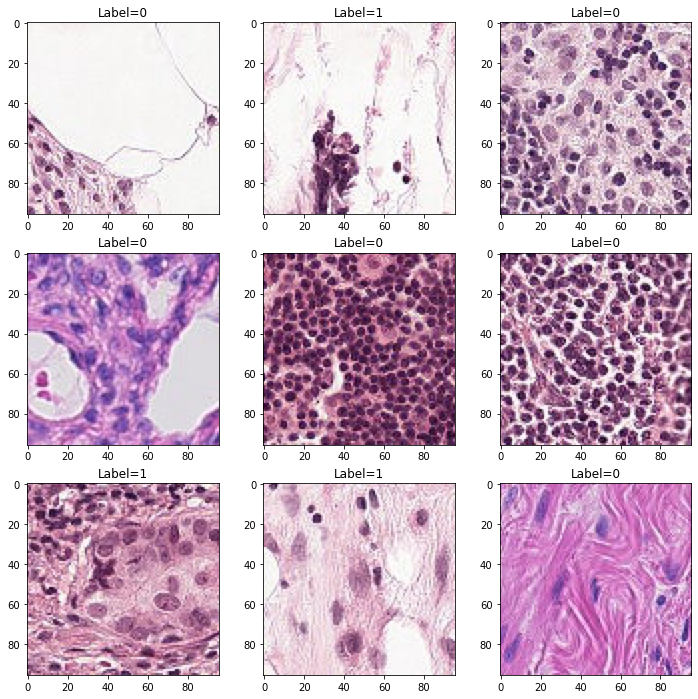

In [10]:
# Plot the first 9 images
plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.title('Label={}'.format(y[i]))
    plt.imshow(X[i])

([<matplotlib.axis.XTick at 0x11461af10>,
 [Text(0, 0, 'no tumor'), Text(0, 0, 'tumor')])

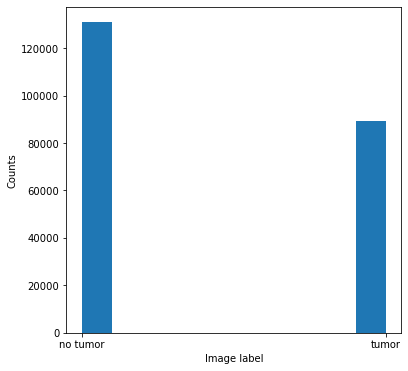

In [11]:
# Distribution of 0 and 1 in the labeled dataset
plt.figure(figsize=(6,6))
plt.hist(y)
plt.xlabel('Image label')
plt.ylabel('Counts')
plt.xticks([0,1], ['no tumor', 'tumor'])

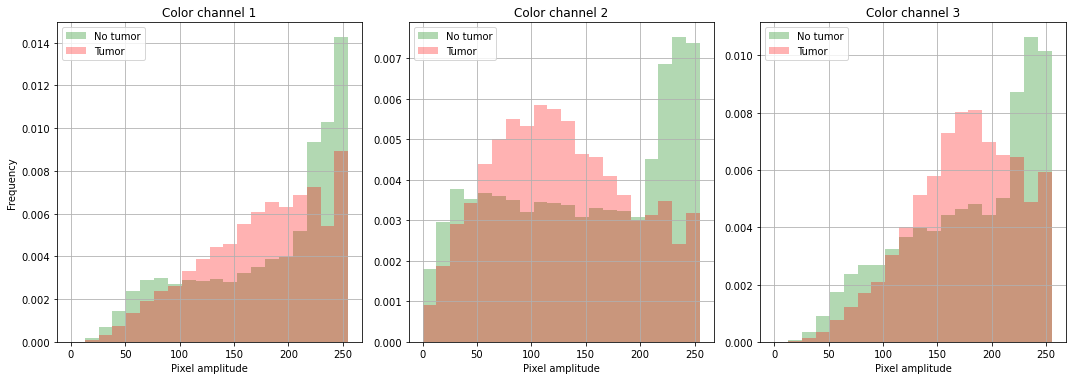

In [12]:
# Explore individual color channels in the image
def subsample(X, y, size=0.1):
    #This function chooses a subsample of images
    samplen = int(len(X)*size)
    Xnew = X[:samplen]
    ynew = y[:samplen]
    return Xnew, ynew

Xnew, ynew = subsample(X, y, size=0.01)

plt.figure(figsize=(15, 15))

plt.subplot(3,3,1)
plt.hist(np.ndarray.flatten(Xnew[ynew==0, :, :, 0]), bins=20, color='green', density=True, alpha=0.3, label='No tumor')
plt.hist(np.ndarray.flatten(Xnew[ynew==1, :, :, 0]), bins=20, color='red', density=True, alpha=0.3, label='Tumor')
plt.title('Color channel 1')
plt.xlabel('Pixel amplitude')
plt.ylabel('Frequency')
plt.grid()
plt.legend(loc='best')
plt.subplot(3,3,2)
plt.hist(np.ndarray.flatten(Xnew[ynew==0, :, :, 1]), bins=20, color='green', density=True, alpha=0.3, label='No tumor')
plt.hist(np.ndarray.flatten(Xnew[ynew==1, :, :, 1]), bins=20, color='red', density=True, alpha=0.3, label='Tumor')
plt.title('Color channel 2')
plt.xlabel('Pixel amplitude')
plt.grid()
plt.legend(loc='best')
plt.subplot(3,3,3)
plt.hist(np.ndarray.flatten(Xnew[ynew==0, :, :, 2]), bins=20, color='green', density=True, alpha=0.3, label='No tumor')
plt.hist(np.ndarray.flatten(Xnew[ynew==1, :, :, 2]), bins=20, color='red', density=True, alpha=0.3, label='Tumor')
plt.title('Color channel 3')
plt.xlabel('Pixel amplitude')
plt.grid()
plt.legend(loc='best')
plt.tight_layout()

# Normalize the images
We wish to normalize each color channel so that they have a mean 0 and std. deviation 1. This is done because if a particular feature has a very large variance compared to others, the objective function is often dominated by this feature and hence it cannot learn effectively from the other features as expected.

In [13]:
norm_img = []

scaler = StandardScaler()

for i in tqdm(range(len(X))):
    raw = X[i]
    for chan in range(raw.shape[2]):
        raw[:, :, chan] = raw[:, :, chan] #scaler.fit_transform(raw[:, :, chan])
    norm_img.append(raw)
    
X1 = np.array(norm_img)
print(X1.shape)

100%|██████████| 220025/220025 [00:01<00:00, 173537.04it/s]


(220025, 96, 96, 3)


# Split the data into train, validation and test sets

In [14]:
X_interim, X_test, y_interim, y_test = train_test_split(X1, 
                                                        y, 
                                                        test_size=0.15, 
                                                        random_state=0)

#Further divide the interim dataset to train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_interim, 
                                                  y_interim, 
                                                  test_size=0.15, 
                                                  random_state=0)

print(X_train.shape[0], ' train samples')
print(X_val.shape[0], ' validation samples')
print(X_test.shape[0], ' test samples')

158967  train samples
28054  validation samples
33004  test samples


# Convolutional Neural Network

In [15]:
num_class = len(np.unique(y_train)) - 1
# Since out classes are not balanced we will use class weights to weight them while model fitting
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
print(class_weights)

[0.83999303 1.2353092 ]


### The Convolutional Neural Network model

In [16]:
def CNN_model(Xt, yt, Xv, yv, epochs=50, batch=1000, patience=6, class_wgt=class_weights):
    #X = np.array(X)
    #y = np.array(y)
    input_dim = Xt[0].shape
    model = Sequential()
    model.add(Conv2D(24, kernel_size=5, strides=2, padding='valid', activation='relu', input_shape=input_dim))
    #model.add(MaxPooling2D(pool_size=3, strides=2, padding='valid'))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, kernel_size=4, strides=2, padding='valid', activation='relu'))
    #model.add(MaxPooling2D(pool_size=3, strides=2, padding='valid'))
    model.add(MaxPooling2D())
    #model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
    #model.add(MaxPooling2D(pool_size=2, strides=1))
    model.add(Flatten())
    model.add(Dense(480, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(336, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_class, activation='sigmoid'))
    
    #Callbacks
    earlystop = EarlyStopping(monitor='val_acc', mode='max', patience=patience)
    checkpoint = ModelCheckpoint('./best_weights.hdf5', 
                                 monitor='val_acc', 
                                 mode='max', 
                                 save_weights_only=False, 
                                 save_best_only=True, 
                                 verbose=1)
    
    adam = keras.optimizers.Adam(lr=0.01)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    print(model.summary())
    
    
    history = model.fit(Xt, 
                        yt, 
                        batch_size=batch, 
                        epochs=epochs, 
                        callbacks=[earlystop, checkpoint], 
                        validation_data=(Xv, yv), 
                        class_weight=class_wgt, 
                        verbose=1)
    
    best_model = keras.models.load_model('./best_weights.hdf5') 
    return history,best_model

In [17]:
y_train.shape

(158967,)

In [18]:
cnn_mod = CNN_model(X_train, y_train, X_val, y_val, epochs=100, batch=1600, patience=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 24)        1824      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        24640     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 480)               768480    
_________________________________________________________________
dropout (Dropout)            (None, 480)               0         
__________

158400/158967 [============================>.] - ETA: 5s - loss: 0.3017 - acc: 0.8689 
Epoch 00022: val_acc did not improve from 0.83813
158967/158967 [==============================] - 1657s 10ms/step - loss: 0.3018 - acc: 0.8688 - val_loss: 0.3668 - val_acc: 0.8352
Epoch 23/100
158400/158967 [============================>.] - ETA: 5s - loss: 0.2962 - acc: 0.8708 
Epoch 00023: val_acc did not improve from 0.83813
158967/158967 [==============================] - 1554s 10ms/step - loss: 0.2962 - acc: 0.8708 - val_loss: 0.3753 - val_acc: 0.8370
Epoch 24/100
158400/158967 [============================>.] - ETA: 5s - loss: 0.2876 - acc: 0.8756 
Epoch 00024: val_acc improved from 0.83813 to 0.83888, saving model to ./best_weights.hdf5
158967/158967 [==============================] - 1578s 10ms/step - loss: 0.2876 - acc: 0.8756 - val_loss: 0.3709 - val_acc: 0.8389
Epoch 25/100
158400/158967 [============================>.] - ETA: 5s - loss: 0.2756 - acc: 0.8815 
Epoch 00025: val_acc improved

### Learning curve for the CNN model

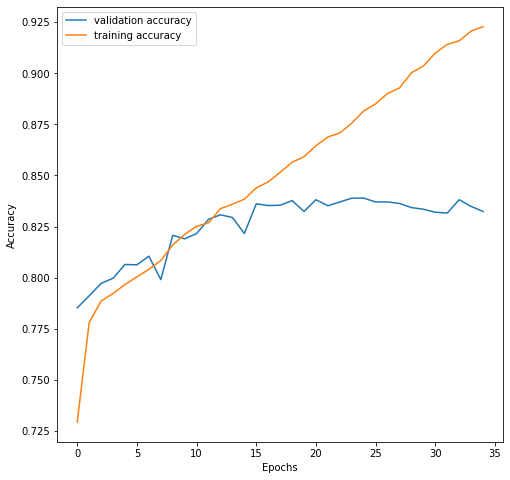

In [24]:
history = cnn_mod[0].history
plt.figure(figsize=(8,8))
plt.plot(history['val_acc'], label='validation accuracy')
plt.plot(history['acc'], label='training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig("./images/learning_CNN.png")
plt.show()

# Predicted results on the test set

In [25]:
best_model = keras.models.load_model('./best_weights.hdf5')

In [26]:
y_test_pred = best_model.predict(X_test)
y_test_pred

array([[0.9874665 ],
       [0.9784726 ],
       [0.0564031 ],
       ...,
       [0.24029654],
       [0.2660812 ],
       [0.89113677]], dtype=float32)

In [28]:
y_test_prob = best_model.predict_proba(X_test)
y_test_prob

array([[0.9874665 ],
       [0.9784726 ],
       [0.0564031 ],
       ...,
       [0.24029654],
       [0.2660812 ],
       [0.89113677]], dtype=float32)

### Evaluate the prediction on the test set using ROC AUC Score

In [31]:
ros_score = roc_auc_score(y_test, y_test_prob[:, 0])

In [32]:
print("The ROC AUC Score on the test set={}".format(ros_score))

The ROC AUC Score on the test set=0.9089141185388655
